In [3]:
from PIL import Image
import torch

from transformers import CLIPTextModel, CLIPTokenizer, AutoTokenizer, AutoModel
from diffusers import AutoencoderKL, StableDiffusionPipeline, UNet2DConditionModel, PNDMScheduler

def run_with_bert(DATASET_PATH = "/workspace/AAA740/Dataset",
                  CHECKPOINT_PATH = "/workspace/AAA740/checkpoints/RadBERT",
                  SAVE_PATH = "./results_image",
                  TEXT_ENCODER="StanfordAIMI/RadBERT",
                  prompt="The organism in question is likely coccidioidomycosis, with a refractile capsule and blue-gray cytoplasm.",
                  height = 512,  # default height of Stable Diffusion
                  width = 512,  # default width of Stable Diffusion
                  num_inference_steps = 50,  # Number of denoising steps
                  guidance_scale = 7.5,  # Scale for classifier-free guidance
                  seed=0,
                  tokenizer_max_length = 77
                  ):
    vae = AutoencoderKL.from_pretrained(CHECKPOINT_PATH, subfolder="vae", use_safetensors=True)
    tokenizer = AutoTokenizer.from_pretrained(TEXT_ENCODER)
    text_encoder = AutoModel.from_pretrained(TEXT_ENCODER)
    unet = UNet2DConditionModel.from_pretrained(CHECKPOINT_PATH, subfolder="unet", use_safetensors=True)
    scheduler = PNDMScheduler.from_pretrained(CHECKPOINT_PATH, subfolder="scheduler")
    
    torch_device = "cuda"
    vae.to(torch_device)
    text_encoder.to(torch_device)
    unet.to(torch_device)
    # prompt = ["The organism in question is likely coccidioidomycosis, with a refractile capsule and blue-gray cytoplasm."]
    
    generator = torch.cuda.manual_seed(seed)  # Seed generator to create the initial latent noise
    batch_size = len(prompt)

    tokenizer.model_max_length = tokenizer_max_length

    text_input = tokenizer(
        prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt"
    )

    with torch.no_grad():
        text_embeddings = text_encoder(**text_input.to(torch_device))[0]
        
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer("", padding="max_length", max_length=max_length, return_tensors="pt")
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    latents = torch.randn(
        (1, unet.config.in_channels, height // 8, width // 8),
        generator=generator,
        device=torch_device,
    )

    from tqdm.auto import tqdm

    scheduler.set_timesteps(num_inference_steps)

    for t in tqdm(scheduler.timesteps):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)

        latent_model_input = scheduler.scale_model_input(latent_model_input, timestep=t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
        # scale and decode the image latents with vae
    latents = 1 / 0.18215 * latents
    with torch.no_grad():
        image = vae.decode(latents).sample

    image = (image / 2 + 0.5).clamp(0, 1).squeeze()
    image = (image.permute(1, 2, 0) * 255).to(torch.uint8).cpu().numpy()
    images = (image * 255).round().astype("uint8")
    image = Image.fromarray(image)
    return image

  0%|          | 0/51 [00:00<?, ?it/s]

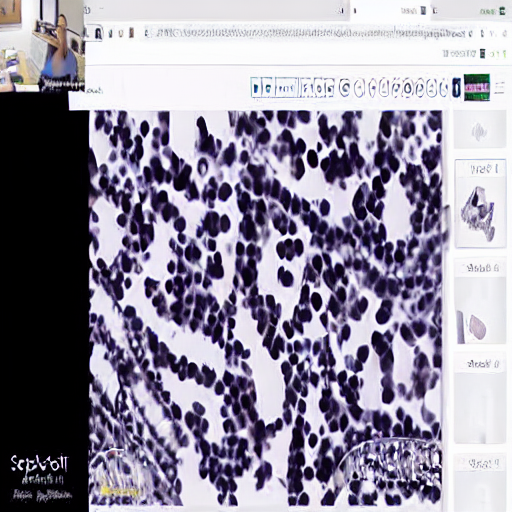

In [4]:
run_with_bert()